In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import h5py

import tensorflow as tf
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
import tensorflow.keras.layers as layer

import os

print("Imports complete")

Imports complete


In [5]:
#!pip install opencv-python
#!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=667b2ecfe6161d39ed8580f4061a80ae0d6928a054906e7492a477fcadb9fc61
  Stored in directory: c:\users\ram khandelwal\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [31]:
ls

 Volume in drive C is Windows
 Volume Serial Number is F01D-1899

 Directory of C:\Users\Ram Khandelwal\Desktop

10-04-2022  17:53    <DIR>          .
03-04-2022  17:10    <DIR>          ..
10-04-2022  16:53    <DIR>          .ipynb_checkpoints
10-04-2022  16:17    <DIR>          COVID-19_Radiography_Dataset
09-12-2021  21:22    <DIR>          cryptochain
25-10-2021  07:13    <DIR>          dbms projects
10-04-2022  17:53            15,458 design_project.ipynb
19-11-2021  23:02    <DIR>          Hostel
07-12-2021  07:49    <DIR>          ihc
06-11-2021  14:52             2,112 second_chance.js
10-04-2022  17:05    <DIR>          tmp
               2 File(s)         17,570 bytes
               9 Dir(s)  69,471,424,512 bytes free


In [42]:
dir = r"tmp\train_data"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "int", class_names = ['COVID','Viral Pneumonia'],
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.1, subset = "training", interpolation = "bicubic")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "int", class_names = ['COVID','Viral Pneumonia'],
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.1, subset = "validation", interpolation = "bicubic")

Found 9922 files belonging to 2 classes.
Using 8930 files for training.
Found 9922 files belonging to 2 classes.
Using 992 files for validation.


In [43]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Viral Pneumonia']


In [44]:
train_ds = train_ds.map(lambda x, y : (x, tf.one_hot(y, depth = 2)))
val_ds = val_ds.map(lambda x, y : (x, tf.one_hot(y,depth = 2)))

In [45]:
lr = 0.000001      # The Learning Rate

In [46]:
def alex_model(input_shape):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    A1 = layer.Conv2D(filters=96, kernel_size=11, strides =(4,4), activation='ReLU')(input_img)
    P1 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(A1)
    
    A2 = layer.Conv2D(filters=256, kernel_size=5, padding='same', activation='ReLU')(P1)
    P2 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2))(A2)
    
    A3 = layer.Conv2D(filters=384, kernel_size=3, padding='same', activation='ReLU')(P2)
    
    A4 = layer.Conv2D(filters=384, kernel_size=3, padding='same', activation='ReLU')(A3)
    
    A5 = layer.Conv2D(filters=256, kernel_size=3, padding='same', activation='ReLU')(A4)
    P5 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2))(A5)
    
    F = layer.Flatten()(P5)
    
    FC6 = layer.Dense(units=1024, activation='ReLU')(F)
    
    FC7 = layer.Dense(units=512, activation='ReLU')(FC6)
    
    outputs = layer.Dense(units = 2, activation = "softmax")(FC7)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model

In [47]:
Alex_model = alex_model((224, 224, 3))
Alex_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Alex_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120

In [48]:
checkpoint_path = 'training/conv/Alex_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)
estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [50]:
historyA = Alex_model.fit(train_ds, 
                          epochs=10, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
Alex_model.save('AlexNet_model.h5')

Epoch 1/10
280/280 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.8726 - f1_score: 0.8244 - precision: 0.8726 - recall: 0.8726
Epoch 1: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 359s 1s/step - loss: 0.3645 - accuracy: 0.8726 - f1_score: 0.8244 - precision: 0.8726 - recall: 0.8726 - val_loss: 0.1808 - val_accuracy: 0.9496 - val_f1_score: 0.9330 - val_precision: 0.9496 - val_recall: 0.9496
Epoch 2/10
280/280 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9613 - f1_score: 0.9498 - precision: 0.9613 - recall: 0.9613
Epoch 2: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 371s 1s/step - loss: 0.1400 - accuracy: 0.9613 - f1_score: 0.9498 - precision: 0.9613 - recall: 0.9613 - val_loss: 0.1215 - val_accuracy: 0.9708 - val_f1_score: 0.9619 - val_precision: 0.9708 - val_recall: 0.9708
Epoch 3/10
280/280 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9731 - f1_score: 0.9656 - precision: 0.9731 - recall: 0.9731
Epoch 3: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 346s 1s/step - loss: 0.0999 - accuracy: 0.9731 - f1_score: 0.9656 - precision: 0.9731 - recall: 0.9731 - val_loss: 0.0996 - val_accuracy: 0.9758 - val_f1_score: 0.9685 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 4/10
280/280 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9787 - f1_score: 0.9728 - precision: 0.9787 - recall: 0.9787
Epoch 4: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 344s 1s/step - loss: 0.0805 - accuracy: 0.9787 - f1_score: 0.9728 - precision: 0.9787 - recall: 0.9787 - val_loss: 0.0889 - val_accuracy: 0.9758 - val_f1_score: 0.9689 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 5/10
280/280 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9825 - f1_score: 0.9777 - precision: 0.9825 - recall: 0.9825
Epoch 5: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 366s 1s/step - loss: 0.0688 - accuracy: 0.9825 - f1_score: 0.9777 - precision: 0.9825 - recall: 0.9825 - val_loss: 0.0849 - val_accuracy: 0.9758 - val_f1_score: 0.9690 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 6/10
280/280 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9847 - f1_score: 0.9805 - precision: 0.9847 - recall: 0.9847
Epoch 6: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 340s 1s/step - loss: 0.0613 - accuracy: 0.9847 - f1_score: 0.9805 - precision: 0.9847 - recall: 0.9847 - val_loss: 0.0768 - val_accuracy: 0.9808 - val_f1_score: 0.9751 - val_precision: 0.9808 - val_recall: 0.9808
Epoch 7/10
280/280 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9857 - f1_score: 0.9818 - precision: 0.9857 - recall: 0.9857
Epoch 7: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 345s 1s/step - loss: 0.0537 - accuracy: 0.9857 - f1_score: 0.9818 - precision: 0.9857 - recall: 0.9857 - val_loss: 0.0721 - val_accuracy: 0.9758 - val_f1_score: 0.9690 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 8/10
280/280 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9876 - f1_score: 0.9842 - precision: 0.9876 - recall: 0.9876
Epoch 8: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 356s 1s/step - loss: 0.0498 - accuracy: 0.9876 - f1_score: 0.9842 - precision: 0.9876 - recall: 0.9876 - val_loss: 0.0701 - val_accuracy: 0.9778 - val_f1_score: 0.9714 - val_precision: 0.9778 - val_recall: 0.9778
Epoch 9/10
280/280 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9879 - f1_score: 0.9846 - precision: 0.9879 - recall: 0.9879
Epoch 9: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 356s 1s/step - loss: 0.0439 - accuracy: 0.9879 - f1_score: 0.9846 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.0704 - val_accuracy: 0.9758 - val_f1_score: 0.9691 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 10/10
280/280 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9906 - f1_score: 0.9881 - precision: 0.9906 - recall: 0.9906
Epoch 10: saving model to training/conv\Alex_cp.ckpt


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\Alex_cp.ckpt\assets


280/280 [==============================] - 339s 1s/step - loss: 0.0398 - accuracy: 0.9906 - f1_score: 0.9881 - precision: 0.9906 - recall: 0.9906 - val_loss: 0.0680 - val_accuracy: 0.9778 - val_f1_score: 0.9716 - val_precision: 0.9778 - val_recall: 0.9778


In [51]:
l = historyA.history.keys()
metrics = list(historyA.history.keys())
df = pd.DataFrame(historyA.history)
df.head()

,loss,accuracy,f1_score,precision,recall,val_loss,val_accuracy,val_f1_score,val_precision,val_recall
0,0.364469,0.872564,"[0.91636044, 0.7324871]",0.872564,0.872564,0.180835,0.949597,"[0.96635264, 0.8995984]",0.949597,0.949597
1,0.139992,0.961254,"[0.9737799, 0.9258148]",0.961254,0.961254,0.121487,0.970766,"[0.9802856, 0.94346976]",0.970766,0.970766
2,0.099932,0.973124,"[0.9816905, 0.94949496]",0.973124,0.973124,0.099628,0.975806,"[0.98367345, 0.95330733]",0.975806,0.975806
3,0.080524,0.978723,"[0.9854961, 0.960084]",0.978723,0.978723,0.088905,0.975806,"[0.98356164, 0.9541985]",0.975806,0.975806
4,0.068756,0.982531,"[0.98807704, 0.96733665]",0.982531,0.982531,0.084914,0.975806,"[0.9835165, 0.9545454]",0.975806,0.975806


In [52]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)


df.head()

,loss,accuracy,f1_score,precision,recall,val_loss,val_accuracy,val_f1_score,val_precision,val_recall
0,36.446920,87.256438,91.636044,87.256438,87.256438,18.083462,94.959676,96.635264,94.959676,94.959676
1,13.999195,96.125418,97.377992,96.125418,96.125418,12.148716,97.076613,98.028558,97.076613,97.076613
2,9.993225,97.312433,98.169053,97.312433,97.312433,9.962790,97.580647,98.367345,97.580647,97.580647
3,8.052352,97.872341,98.549610,97.872341,97.872341,8.890458,97.580647,98.356164,97.580647,97.580647
4,6.875570,98.253077,98.807704,98.253077,98.253077,8.491367,97.580647,98.351651,97.580647,97.580647


C:\Users\Ram Khandelwal\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Ram Khandelwal\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Ram Khandelwal\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().ren

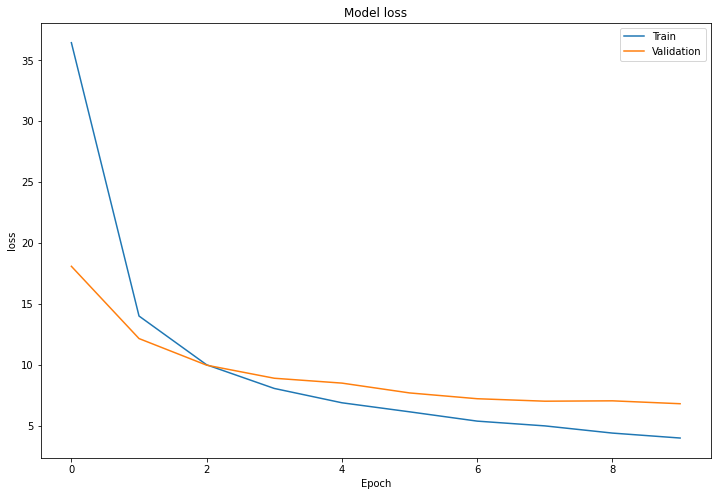

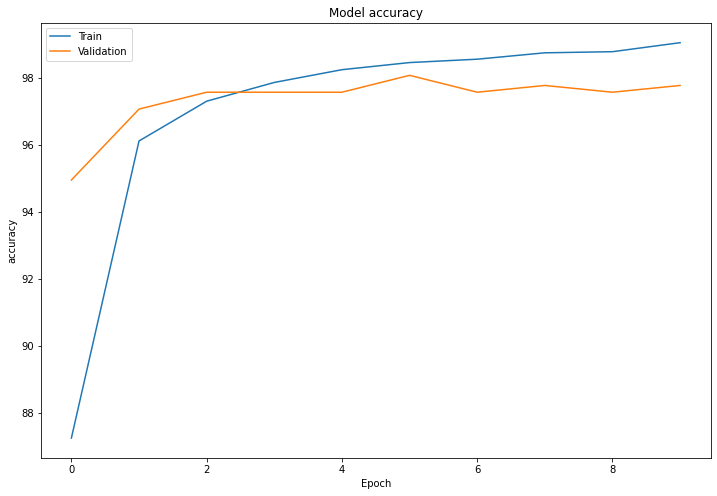

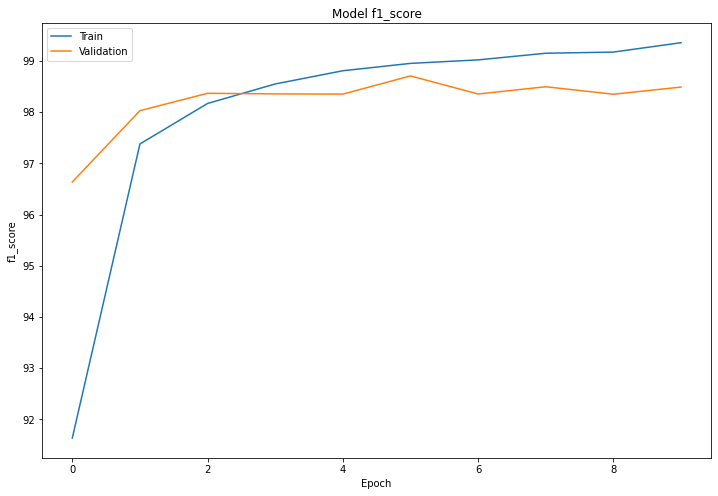

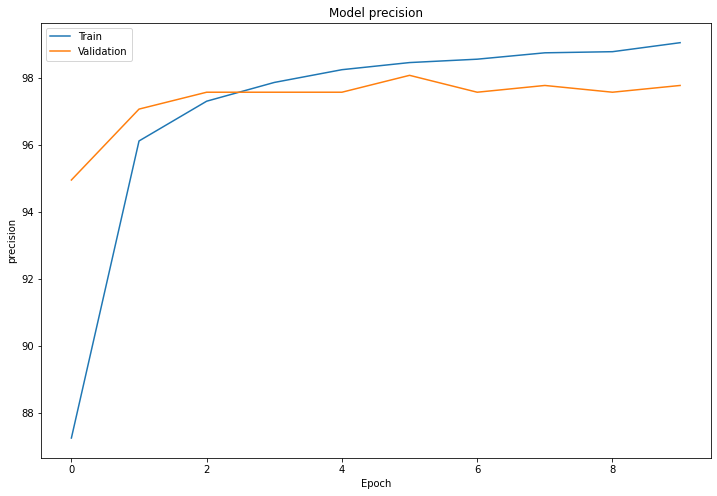

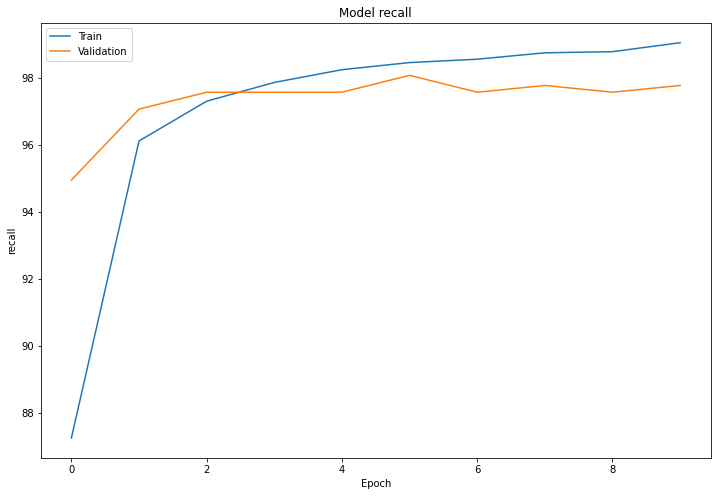

In [53]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'Train',val:'Validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [54]:
def resnet_model(input_shape):
    
    input_img = tf.keras.Input(input_shape)
    
    base = tf.keras.applications.resnet50.ResNet50(input_shape = input_shape, weights = 'imagenet',
                                                   include_top = False, input_tensor = input_img)
    
    base.trainable = False
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=3072, activation='relu')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=512, activation='relu')(N2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 2, activation = 'softmax')(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

In [55]:
checkpoint_path = 'training/conv/ResnetImgnet_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [56]:
Resnet_model = resnet_model((224, 224, 3))
Resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss='binary_crossentropy',
                     metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Resnet_model.summary()

94781440/94765736 [==============================] - 11s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization) 

                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block4_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
          

 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization) 

Total params: 31,479,170
Trainable params: 7,880,194
Non-trainable params: 23,598,976
__________________________________________________________________________________________________


In [ ]:
historyRI = Resnet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[cp_callback, estop])

Resnet_model.save('ResNet_model.h5')

Epoch 1/10
280/280 [==============================] - ETA: 0s - loss: 1.4412 - accuracy: 0.6577 - f1_score: 0.6359 - precision_1: 0.6577 - recall_1: 0.6577
Epoch 1: saving model to training/conv\ResnetImgnet_cp.ckpt
INFO:tensorflow:Assets written to: training/conv\ResnetImgnet_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\ResnetImgnet_cp.ckpt\assets


280/280 [==============================] - 978s 3s/step - loss: 1.4412 - accuracy: 0.6577 - f1_score: 0.6359 - precision_1: 0.6577 - recall_1: 0.6577 - val_loss: 1.1391 - val_accuracy: 0.8548 - val_f1_score: 0.8345 - val_precision_1: 0.8548 - val_recall_1: 0.8548
Epoch 2/10
280/280 [==============================] - ETA: 0s - loss: 1.2080 - accuracy: 0.7942 - f1_score: 0.7751 - precision_1: 0.7942 - recall_1: 0.7942
Epoch 2: saving model to training/conv\ResnetImgnet_cp.ckpt
INFO:tensorflow:Assets written to: training/conv\ResnetImgnet_cp.ckpt\assets


INFO:tensorflow:Assets written to: training/conv\ResnetImgnet_cp.ckpt\assets


280/280 [==============================] - 1246s 4s/step - loss: 1.2080 - accuracy: 0.7942 - f1_score: 0.7751 - precision_1: 0.7942 - recall_1: 0.7942 - val_loss: 1.0056 - val_accuracy: 0.8992 - val_f1_score: 0.8821 - val_precision_1: 0.8992 - val_recall_1: 0.8992
Epoch 3/10
 83/280 [=======>......................] - ETA: 10:55 - loss: 1.1421 - accuracy: 0.8294 - f1_score: 0.8104 - precision_1: 0.8294 - recall_1: 0.8294

In [ ]:
l = historyRI.history.keys()
print(l, len(l), type(l))
metrics = list(historyRI.history.keys())

df = pd.DataFrame(historyRI.history)

In [ ]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)

df.head()

In [ ]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [ ]:
def vgg_model(input_shape, weights='imagenet',transfer=True):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    base = tf.keras.applications.VGG16(input_shape = input_shape, weights = weights,
                                       include_top = False, input_tensor = input_img)
    base.trainable = not(transfer)
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 256, activation = 'ReLU')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 128, activation = 'ReLU')(A2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 2, activation = "softmax")(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

In [ ]:
vggnet_I = vgg_model(input_shape=(224,224,3), weights='imagenet',transfer=True)

vggnet_I.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
vggnet_I.summary()

In [ ]:
checkpoint_path = 'training/conv/VGG16Imgnet_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [ ]:
historyVI = vggnet_I.fit(train_ds, 
                          epochs=10, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
vggnet_I.save('VGG16_model.h5')

In [ ]:
l = historyVI.history.keys()
print(l, len(l), type(l))
metrics = list(historyVI.history.keys())

df = pd.DataFrame(historyVI.history)

In [ ]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)


df.head()

In [ ]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))
  
  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  #X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, X, name = 'GoogLeNet')

  return model

In [ ]:
def build_inception():
    
    base = GoogLeNet()
    
    A0 = base.output
    
    N1 = layer.BatchNormalization()(A0)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=3072, activation='relu')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=512, activation='relu')(N2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 2, activation = "softmax")(N3)
    
    model = tf.keras.Model(inputs = base.input, outputs = outputs)
    
    return model    

In [ ]:
Inc_model = build_inception()
Inc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Inc_model.summary()

In [ ]:
checkpoint_path = 'training/conv/InceptionNet.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [ ]:
historyInc = Inc_model.fit(train_ds, 
                           epochs=10, 
                           validation_data=val_ds, 
                           callbacks = [cp_callback, estop])
Inc_model.save('InceptionNet_model.h5')

In [ ]:
l = historyInc.history.keys()
print(l, len(l), type(l))
metrics = list(historyInc.history.keys())

df = pd.DataFrame(historyInc.history)

In [ ]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)


df.head()

In [ ]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [ ]:
def Mobilenet_model(input_shape, weights=None, transfer=False):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    base = tf.keras.applications.MobileNetV2(input_shape = input_shape, weights = weights, 
                                             include_top = False, input_tensor = input_img)
    base.trainable = not(transfer)
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 256, activation = 'ReLU')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 128, activation = 'ReLU')(A2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 2, activation = "softmax")(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

In [ ]:
mobile_I = Mobilenet_model(input_shape=(224,224,3), weights='imagenet',transfer=True)

mobile_I.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
                 
mobile_I.summary()

In [ ]:
checkpoint_path = 'training/conv/Mobile_image_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [ ]:
historyMi = mobile_I.fit(train_ds, 
                          epochs=10, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
mobile_I.save('MobileNet_model.h5')

In [ ]:
l = historyMi.history.keys()
print(l, len(l), type(l))
metrics = list(historyMi.history.keys())

df = pd.DataFrame(historyMi.history)

In [ ]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)


df.head()

In [ ]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
img_size = (224, 224)
UNet_model = get_model(img_size, 2)
UNet_model.summary()

In [ ]:
def Unet_classifier(base):
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=3072, activation='relu')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=512, activation='relu')(N2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 2, activation = "softmax")(N3)
    
    model = tf.keras.Model(inputs = base.input, outputs = outputs)
    
    return model

In [ ]:
Unet = Unet_classifier(UNet_model)
Unet.summary()

In [ ]:
Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
checkpoint_path = 'training/conv/UNet1.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [ ]:
historyU = Unet.fit(train_ds, epochs=10, validation_data=val_ds, callbacks = [cp_callback, estop])
Unet.save('UNet.h5')

In [ ]:
l = historyU.history.keys()
print(l, len(l), type(l))
metrics = list(historyU.history.keys())

df = pd.DataFrame(historyU.history)

In [ ]:
def f1_mod(x):
    return x[0]

def per_cent(x):
    return x*100
    
df['f1_score'] = df['f1_score'].apply(f1_mod)
df['val_f1_score'] = df['val_f1_score'].apply(f1_mod)

for i in df.columns:
    df[i] = df[i].apply(per_cent)


df.head()

In [ ]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)